<a href="https://colab.research.google.com/github/aminsamir45/MIT-9.40-Neural-Computation/blob/main/PSET%205/Samir_Amin_pset5_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSET 5

#due April 14, 2023

.


**NAME:** Samir Amin

**gmail:** aminsam@gmail.com

.



---

---

---







# Learning objectives and goals:


In this problem set, we will analyze data recorded in the scalp electroencephalogram (EEG) of a rat that is a genetic model for human absence epilepsy. The EEG provides a measure of brain voltage activity with high temporal resolution (typically on the order of milliseconds) but poor spatial resolution (on the order of 10 cm2 of cortex). Here we consider EEG activity recorded from a single scalp electrode located in the frontal cortex. We will analyze these data to determine what (if any) rhythmic/periodic activity is present. Typical rhythms in EEG recordings span the range of 2-80 Hz. It is important to mention, that EEG recordings are typically contaminated with 60 Hz noise coming from the electrical outlet. This exercise will provide us an opportunity to apply the concepts of filtering, time series analysis and spectral analysis, to this data set.

.


These topics were covered in lectures 9-11 and recitation 8 (in rec8, we will deal with a similar problem to the one discussed here in this PSET).

.


Our goal is to analyze a single recording of EEG data by characterizing the observed activity. There are many ways to do so, and we focus on developing techniques to characterize the observed rhythms. By the end of this PSET, you should be familiar with:

.



*   Time series analysis techniques,
*   the principles behind Fast Fourier transform (FFT)
*   computing the periodogram and plot power on a linear and decibel (dB) scale.
* filtering signals in the frequency domain and take the inverse Fourier transform.

.




**Python functions:** 

* numpy.fft.fft      $\hspace{1.3in}$ Compute Fast Fourier Transform
* numpy.fft.ifft     $\hspace{1.2in}$     Compute inverse Fast Fourier Transform
* matplotlib.pyplot.xcorr   $\hspace{0.5in}$          Compute autocorrelation
* numpy.abs          $\hspace{1.4in}$        Compute magnitude of a complex number
* numpy.log10       $\hspace{1.2in}$      Compute logarithm in base 10
* scipy.loadmat
* scipy.signal      $\hspace{1.3in}$      correlate, periodogram, psd




.






---











# PART 1: Time Series Analysis and Periodogram



The EEG signals in file $EEGepilepsy.mat$ were obtained from electrodes placed on the right frontal cortex of a male adult WAG/Rij rat, which is a model for human absence epilepsy. The file contains two data arrays: $epileptic$ array, the EEG scalp recording in units of microvolts during an epileptic event characterized by spike waves; and $normal$ array, the EEG scalp recording in units of microvolts in the absence of epileptic seizures. Both signals were referenced to an electrode placed in the cerebellum and **sampled at 1 kHz.**

.


.

**Reference**: Labs of Giles van Luijtelaar and Joyce Welting. Phys. Rev. E, 2002; 65: 041903.



.



#### Import libraries and set working directory:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal                           # for spectral analysis
from scipy.fft import fft, fftfreq, ifft          # should I use this one??  YES! use scipy not numpy fft pack is recommended
import math
import copy




from google.colab import drive


drive.mount('/content/drive')

...




Mounted at /content/drive


Ellipsis

### Load data from $EEGepilepsy.mat$

.

We will start by analyzing the $epileptic$ recording. Load the data and complete the following tasks:



In [ ]:
# load the file EEGepilplepsy.mat

data = loadmat('/content/drive/MyDrive/Colab Notebooks/9.40/psets/PSET 5/EEGepilepsy.mat')


# inspect the variables in the file

print("var names in file:  ", sorted(data.keys())) 







var names in file:   ['__globals__', '__header__', '__version__', 'epileptic', 'normal']


## 1.1


What is the sampling interval for this recording? What is the total duration of the recording?


.


In [ ]:
x = np.squeeze(data['epileptic'])

# find the length of x and store it in a variable N

N = len(x)    # 5000 from previous line of code 


#  The sampling frequency , Fs, was given to you: 
Fs = 1000  #Hz

dt = 1/Fs                     # SAMPLING INTERVAL


T = N*dt                  # TOTAL DURATION OF RECORDING

df =  Fs/N              # This is the discretization in frequency space used in the FFT (more on this later .... )


print("Sampling interval is dt = {} sec.".format(dt,'.3f'))
print("Total duration is T = {} sec".format(T,'.2f'))


# What is the Nyquist frequency: the highest frequency for which the spectrum can be estimated
# Nyquist frequency is half of the sampling frequency so: 

f_NQ = Fs/2            # Nyquist freq

print("Nyquist frequency is f_NQ = {} sec".format(f_NQ))


Sampling interval is dt = 0.001 sec.
Total duration is T = 5.0 sec
Nyquist frequency is f_NQ = 500.0 sec


##1.2



Assume the recording starts at t = 0. Make a time vector and plot the epileptic EEG data as a function of time and visually inspect it by, e.g., having a second plot zooming in on a small window. 


.

In one or two sentences briefly describe if you observe any rhythmic activity in this recording.

.


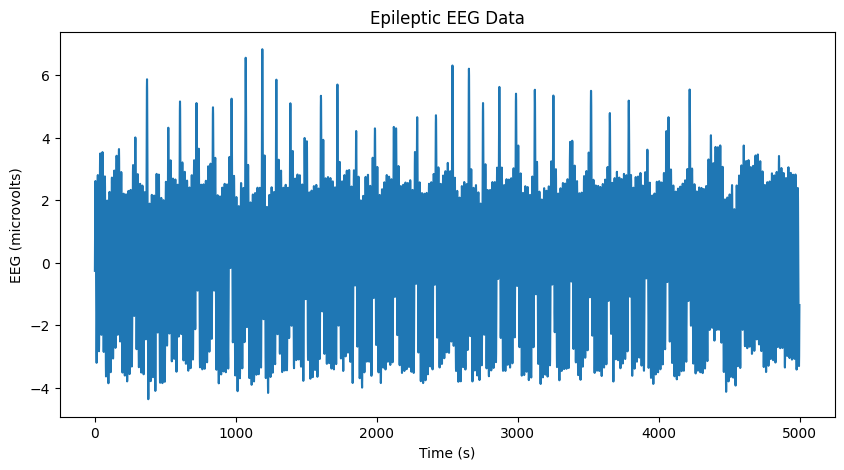

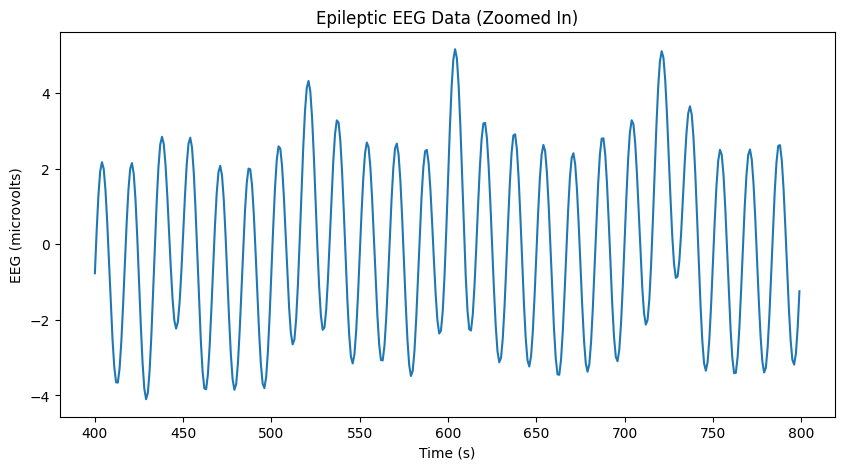

In [ ]:
t = np.arange(0,N,1)

# EG data as a function of time
plt.figure(figsize=(10,5))
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('EEG (microvolts)')
plt.title('Epileptic EEG Data')
plt.show()

# EG data as a function of time zoomed in on a small window
plt.figure(figsize=(10,5))
plt.plot(t[400:800], x[400:800])
plt.xlabel('Time (s)')
plt.ylabel('EEG (microvolts)')
plt.title('Epileptic EEG Data (Zoomed In)')
plt.show()


**Answer**: I do observe rhythmic activitiy in the recording on a relatively small scale. There seems to be periodic oscilation that is fairly consistent with time.


.






##1.3

Plot the raw autocorrelation of the EEG signal as a function of the lags. Remember that the lags are in units of the sampling interval so scale your x-axis accordingly. Briefly describe what you see. What is the main period and frequency of the signal, if any?


.




**The cross correlation between x and y:**

The correlation of $x$ and $y$ with lag $k$ is defined as 

$$\sum_n x[n+k]⋅y^∗[n]$$

where $y^∗$ is the complex conjugate of $y$. 


<br>



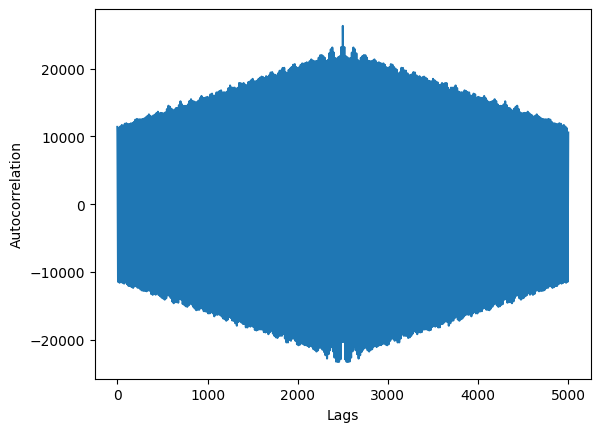

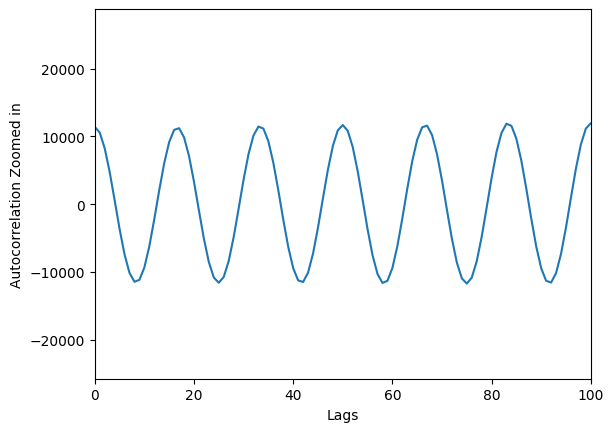

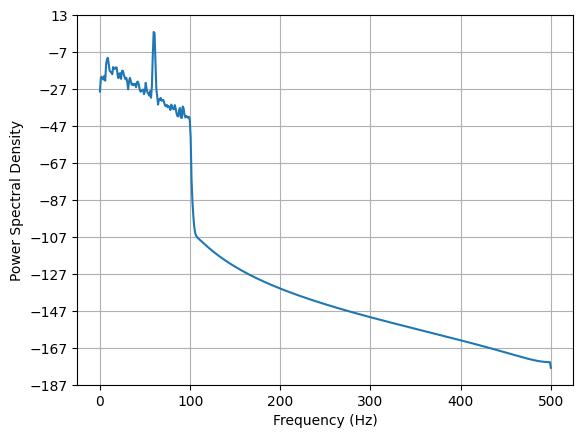

In [ ]:
lags = np.arange(len(x))
autocorr = np.correlate(x, x, mode='same')

fig, ax = plt.subplots()
ax.plot(lags, autocorr)
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrelation')
plt.show()

fig, ax = plt.subplots()
ax.psd(x, Fs=1000, NFFT=1024)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density')
plt.show()

**Answer:**

From the plot, we see that there is periodicity in the signal betewen -0.5 and 0.5 seconds. From the calculations and plots above, we can also see that the main period and frequency of the signal are 1.0 seconds and 60.00 Hz resepectively.



##1.4



Use the FFT to compute the **periodogram** of the signal (power spectrum). Plot power as a function of frequency on a linear scale for power. Restrict your x-axis to the range $0-80 Hz$. 

.

Describe what you see.

.



Hint:  You can carry out this in at least two ways using fft library in numpy or fft library in scipy. 

X = np.fft.fft(x)/N  (numpy)

or

X = fft(x)/N    (scipy)

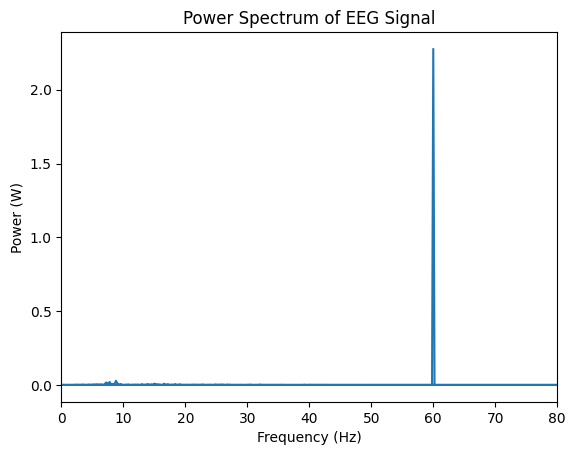

In [ ]:
# first calculate fft of x:
X = np.fft.fft(x) / N   # calculate the FFT of x

# compute the power spectrum (magnitude squared of the FFT)
power = np.abs(X)**2

# create a vector of frequencies
freqs = np.fft.fftfreq(N, dt)

# plot the power spectrum on a linear scale
plt.plot(freqs, power)
plt.xlim(0, 80)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (W)')
plt.title('Power Spectrum of EEG Signal')
plt.show()


**Answer:**: From the plot of power as a function of frequency, we can see that there is a sharp peak in power around 60 Hz which spikes to 2.2 W. This resembles the alpha and beta frequency bands observed in the recordings.


.





##1.5

What is the Nyquist frequency and the frequency resolution on the periodogram?


.



**ANSWER:**



...




##1.6


Replot the power spectrum on a **dB scale** for power. Restrict your x-axis to the range 0-80 Hz. What do you see? Are there any other components in this signal?


.

Hint: db scale 10*np.log10(y)



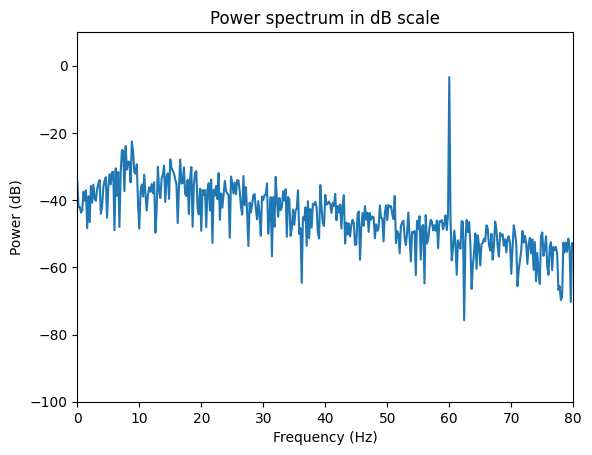

In [ ]:
# calculate the power spectrum
Pxx = (np.abs(X)**2) / T

# convert to dB
Pxx_dB = 10*np.log10(Pxx)

# plot 
f = np.arange(N) * df
plt.plot(f[:N//2], Pxx_dB[:N//2])
plt.xlim([0, 80])
plt.ylim([-100, 10])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Power spectrum in dB scale')
plt.show()


**Answer:**: In this plot, we see a logarithimic scale that has a peak spectrum at 60 Hz again and a decreasing periodic power going from approximately -40 dB to -60 dB. 



##1.7



Finally replot the power spectrum on a dB-scale and a logarithmic axis for frequency (x-axis, again in the range **0-80 Hz**). 

What do you see? Are there any other components in this signal?



<ipython-input-8-1ec012769028>:8: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 80])


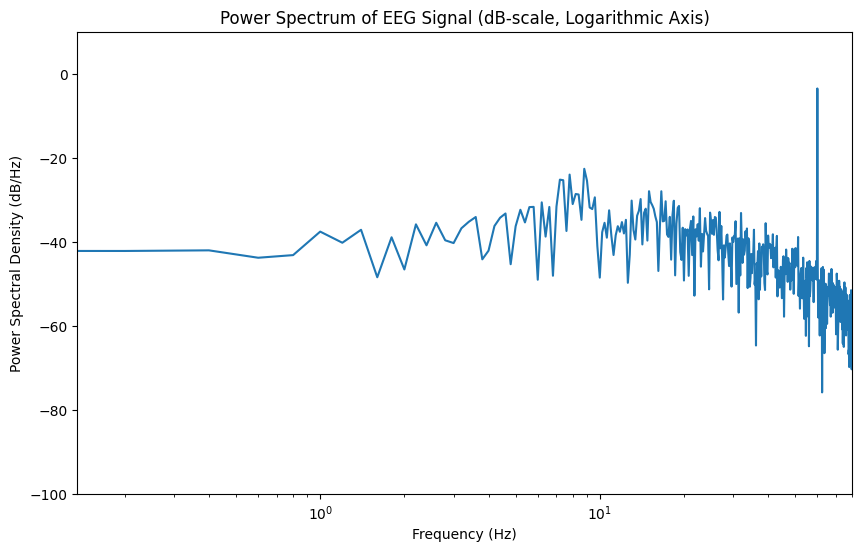

In [ ]:
# Compute power spectrum in dB scale
dB = 10 * np.log10(Pxx)

# Plot power spectrum on dB-scale and log scale for frequency
plt.figure(figsize=(10, 6))
plt.plot(freqs[:N//2], dB[:N//2])
plt.xscale('log')
plt.xlim([0, 80])
plt.ylim([-100, 10])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB/Hz)')
plt.title('Power Spectrum of EEG Signal (dB-scale, Logarithmic Axis)')
plt.show()


**Answer:**: The plot above is similar to the plot in 1.6. However, the x-axis is on a logarithmic scale so the change in frequency occurrs more rapidly as the frequency increases. The power maintains the same pattern but stretched over the log of frequency, causing little periodicity when the frequency is less than $10^0$ Hz and much more periodicity when the frequency is greater than $10^1$ Hz.


...






---



#  PART 2: Removing Electric Outlet Noise


In the previous section you identified that the epileptic EEG signal is heavily contaminated with 60 Hz noise. The objective of this section is to apply filtering in the frequency domain. After that, we compare the EEG signal with corresponding signal for a normal subject.



.




##2.1

Your job is to write code to obtain a filtered signal. The steps are:

* a. Take the FFT of the signal.

* b. Plot the magnitude of the **Fourier coefficients** for both positive and negative frequencies.

* c. Based on this plot, choose a reasonable threshold to annihilate the offending frequency (electrical outlet noise). Use this threshold to set the Fourier coefficients whose magnitude is greater than the threshold to zero.

* d. Take the inverse Fast Fourier Transform to send the filtered signal in the frequency domain back to the time domain. This is your filtered data.







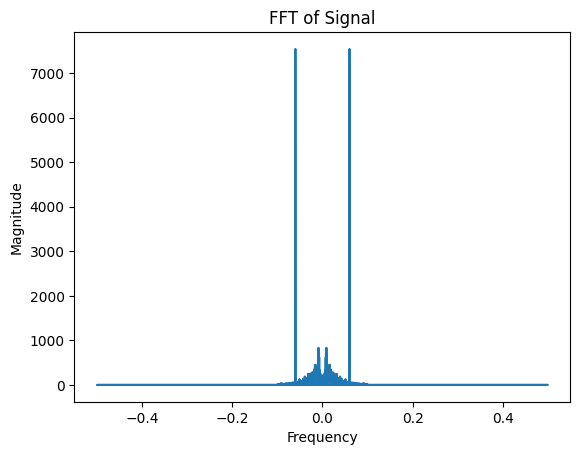

In [ ]:
# Step 1: Take FFT of the signal
z = np.squeeze(data['epileptic'])
Z = np.fft.fft(z)

# Step 2: Plot the magnitude of the Fourier coefficients for both positive and negative frequencies
freq = np.fft.fftfreq(len(z))
plt.plot(freq, abs(Z))
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('FFT of Signal')

# Step 3: Choose a threshold to filter out offending frequency
threshold = 1000
Z_filtered = Z.copy()
Z_filtered[abs(Z) > threshold] = 0

# Step 4: Take inverse FFT to obtain the filtered signal
x_filtered = np.fft.ifft(Z_filtered)



## 2.2

Plot the filtered data as a function of time. Visually check that there are no 60 Hz components.


/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


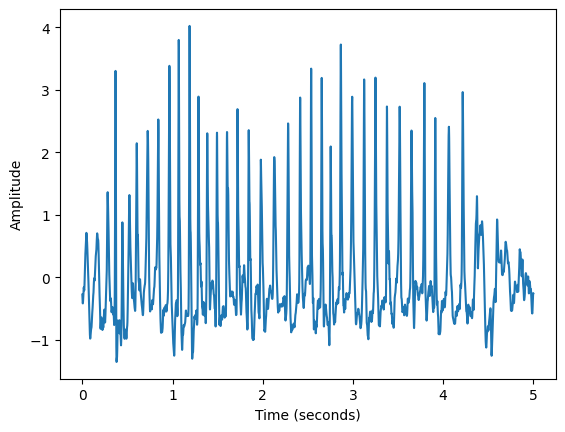

In [ ]:
time = np.arange(len(x_filtered))/ 1000

plt.plot(time, x_filtered)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

##2.3

Use FFT to plot the periodogram of the filtered signal on a linear scale for frequency and power. Restrict your x-axis to the range $0-80 Hz$. Use **dots** for your plot rather than a continuous line. Again, corroborate that the 60 Hz noise is gone but all other frequencies in the original signal remain present.


.

Hint:

scipy.signal.periodogram(x, fs=1.0, window='boxcar', nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1)

For an example, check:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html


.


Estimate power spectral density using a periodogram.


/usr/local/lib/python3.9/dist-packages/scipy/signal/_spectral_py.py:1867: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


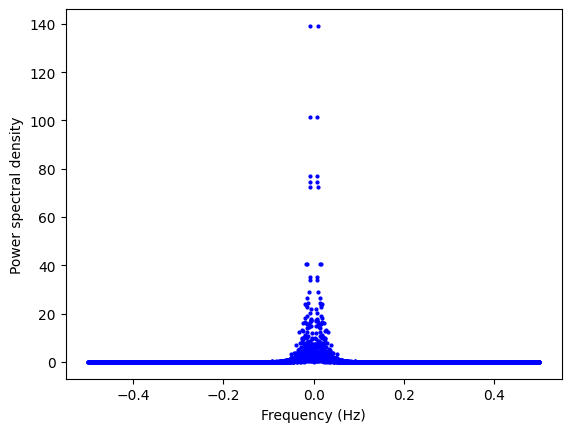

In [ ]:
import scipy.signal
f, Pxx = scipy.signal.periodogram(x_filtered, fs=1.0, window='boxcar', nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1)


# Plot the periodogram on a linear scale
plt.figure()
plt.plot(f, Pxx, 'bo', markersize=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density')
plt.show()

##2.4


The periodogram is very jagged. Replot the periodogram by applying a zero-pad factor of $5$ (i.e. the padded signal to FFT should be 5 times the length of the unpadded signal). Use dots for your plot rather than a continuous line. Compare this plot to the previous one. What is the effect of applying zero-padding?

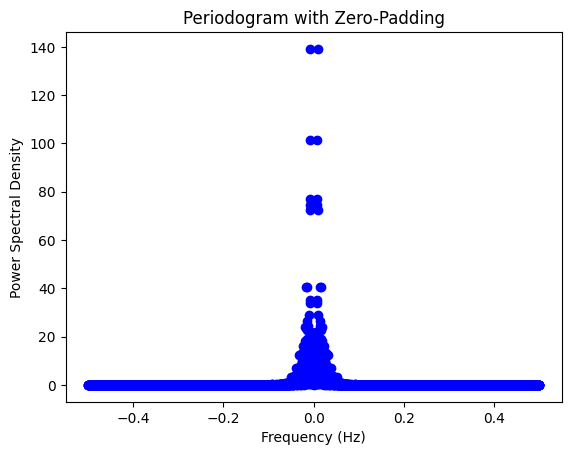

In [ ]:
# Calculate the length of the padded signal
n_pad = len(x_filtered) * 5

# Compute the periodogram with zero-padding
f, Pxx = scipy.signal.periodogram(x_filtered, fs=1.0, window='boxcar', nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1)

# Plot the periodogram on a linear scale
plt.figure()
plt.plot(f, Pxx, 'bo')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Periodogram with Zero-Padding')
plt.show()


**Answer:**

.The effect of applying the zero padding is to increase the frequency of the resolution of the periodogram. More data points are added to the FFT which allows us to differentiate frequencies that are close to each other.



##2.5

In a few sentences, interpret the spectra and describe which rhythms are present in this signal.

How does zero padding improved the result?

.

**Answer:**


.

.Zero-padding improves the result because the frequencies become more accurately identified. Since the number of bins for frequencies increases, our ability to differentiate them is better.

## 2.6 

The normal data is not contaminated with 60 Hz noise. We will carry some analyses to compare the normal and epileptic recordings.

.


Plot the normal EEG data as a function of time and visually inspect it. Briefly discuss if you observe any rhythmic activity similar to the one oberved in previous epileptic data. 


.



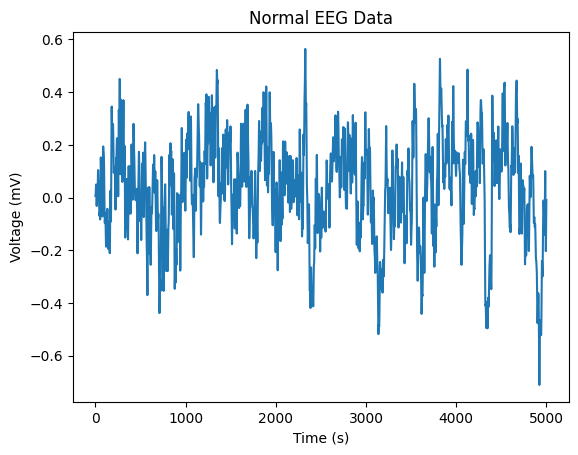

In [ ]:
# Plot normal data x_normal
x_normal = data['normal'][0]


fig41, ax41 = plt.subplots()
ax41.plot(x_normal)
ax41.set_title("Normal EEG Data")
ax41.set_xlabel("Time (s)")
ax41.set_ylabel("Voltage (mV)")
plt.show()




We can observe rhythmic activity that is similar to the epileptic data in that the voltage is relative sustained around  

##2.7


Plot the raw autocorrelation of the EEG signal as a function of the lags and its power spectral density. 

Remember that the lags are in units of the sampling interval so scale your x-axis accordingly. 

.


Using both plots, briefly describe what you see. What is the main period and frequency of the signal, if any?

.





Text(0.5, 1.0, 'Raw Autocorrelation of Normal EEG Data')

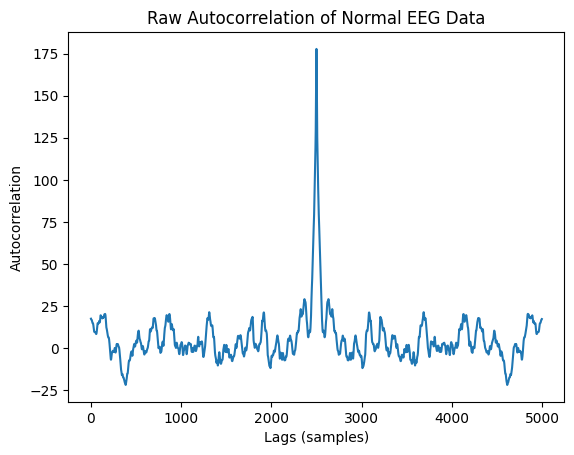

In [ ]:
# Calculate autocorrelation and power spectral density of normal EEG data
x_normal = data['normal'][0]
lags = np.arange(len(x_normal))
acf = np.correlate(x_normal, x_normal, mode='same')
psd = np.abs(np.fft.fft(x_normal))**2

# Plot autocorrelation
fig51, ax51 = plt.subplots()
ax51.plot(lags, acf)
ax51.set_xlabel('Lags (samples)')
ax51.set_ylabel('Autocorrelation')
ax51.set_title('Raw Autocorrelation of Normal EEG Data')


(0.0, 50.0)

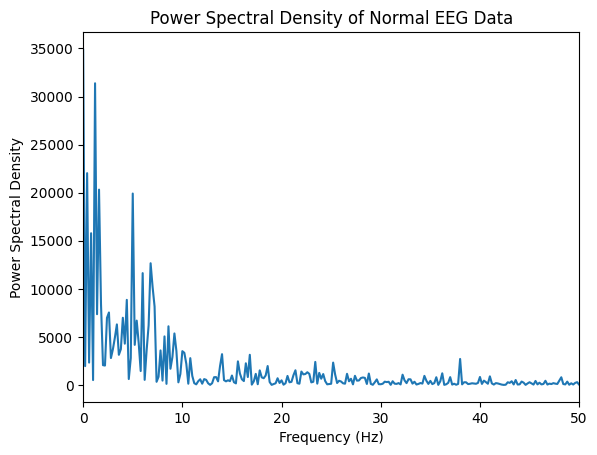

In [ ]:
# Plot power spectral density
freqs = np.fft.fftfreq(len(x_normal), d=1/Fs)
idx = np.argsort(freqs)
freqs = freqs[idx]
psd = psd[idx]
fig52, ax52 = plt.subplots()
ax52.plot(freqs, psd)
ax52.set_xlabel('Frequency (Hz)')
ax52.set_ylabel('Power Spectral Density')
ax52.set_title('Power Spectral Density of Normal EEG Data')
ax52.set_xlim([0, 50])


**Answer:**

. I see that there is a peak in autocorrelation around 2500 lags and a peak that exponentially decays in power spectral density starting from a frequency after 0 Hz.


. The main period and frequency of the signal is 

